# AnomalyTransformer
- unsupervised learning (no label)
- reconstrunction-based approach

In [1]:
import os

In [2]:
os.listdir('../data/timeseries/AnomalyTransformer/MSL/')

['.DS_Store', 'MSL_test_label.npy', 'MSL_train.npy', 'MSL_test.npy']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
msl_train = np.load('../data/timeseries/AnomalyTransformer/MSL/MSL_train.npy')
msl_test_label = np.load('../data/timeseries/AnomalyTransformer/MSL/MSL_test_label.npy')
msl_test = np.load('../data/timeseries/AnomalyTransformer/MSL/MSL_test.npy')

In [5]:
anomaly_ratio = msl_test_label.sum() / len(msl_test_label)
print(f'Anomaly Ratio in test dataset is {anomaly_ratio * 100:.2f} %')

Anomaly Ratio in test dataset is 10.53 %


In [6]:
msl_train.shape

(58317, 55)

sample data 1 dim


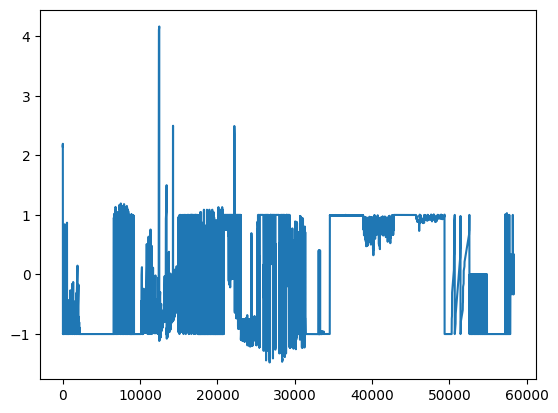

In [7]:
print("sample data 1 dim")
plt.plot(msl_train[:, 0]);

In [8]:
import argparse
from copy import deepcopy
from datetime import datetime

import pandas as pd
import torch
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import TensorBoardLogger

def define_argparser():
    parser = argparse.ArgumentParser()

    parser.add_argument("--project", default="Time Series Anomaly Detection")
    parser.add_argument("--model", default="LitAnomalyTransformer")
    parser.add_argument(
        "--batch_size",
        type=int,
        default=512,
        help="input batch size for training (default: 512)",
    )
    parser.add_argument(
        "--epochs", type=int, default=2, help="number of epochs to train (default: 2)"
    )
    parser.add_argument("--cuda", type=int, default=0, help="0 for cpu -1 for all gpu")

    config = parser.parse_args([])  # jupyter에서는 args=[] 이용

    if config.cuda == 0 or not torch.cuda.is_available():
        config.cuda = "cpu"
    else:
        config.cuda = "gpu"

    current_time = str(datetime.today()).split(".")[0]
    config.current_time = current_time

    return config

In [9]:
config = define_argparser()

In [10]:
config

Namespace(project='Time Series Anomaly Detection', model='LitAnomalyTransformer', batch_size=512, epochs=2, cuda='cpu', current_time='2023-07-02 14:57:45')

## 01.set dataset

In [11]:
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader

In [12]:
scaler = StandardScaler()
scaler.fit(msl_train)
scaled_train = scaler.transform(msl_train)

In [13]:
train_ratio = 0.8
num_train = int(len(scaled_train)*train_ratio)

train = scaled_train[:num_train, :]
valid = scaled_train[num_train:, :]

print(f'train.shape={train.shape}')
print(f'valid.shape={valid.shape}')

train.shape=(46653, 55)
valid.shape=(11664, 55)


In [14]:
from catchMinor.data_load.dataset import WindowDataset

In [15]:
train_dataset = WindowDataset(train, train, window_size=128, overlaps=False, shape='wf')
valid_dataset = WindowDataset(valid, valid, window_size=128, overlaps=False, shape='wf')

In [16]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size)

## 02.set model

In [17]:
from catchMinor.time_series_model.AnomalyTransformer.at_config import *

In [18]:
model_config = AnomalyTransformer_config(feature_dim=55)
loss_config = AnomalyTransformer_loss_func_config()
optim_config = AnomalyTransformer_optimizer_config()


In [19]:
from catchMinor.time_series_model.AnomalyTransformer.lit_at import LitAnomalyTransformer

In [20]:
model = LitAnomalyTransformer(model_config, optim_config, loss_config)

2023-07-02 14:57:45,720 - INFO - AnomalyTransforme layer is made.


## 03. train

In [21]:
# callback: tensorboard
TensorBoard_logger = TensorBoardLogger(
    save_dir="./log", name=config.model, version=config.current_time
)

# callback: progrss bar
rich_progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="Anomaly Detection",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
    ),
    leave=True,
)

# callback: save the best model in every epochs
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",
    dirpath="./checkpoints/",
    filename="model_name-{epoch}-{valid_acc:.4f}",
    save_top_k=1,
    mode="min",
)

# callback: early stop
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=2)

# trainer
trainer = Trainer(
    log_every_n_steps=1,
    accelerator=config.cuda,
    logger=TensorBoard_logger,
    max_epochs=config.epochs,
    deterministic=True,
    callbacks=[early_stopping_callback, rich_progress_bar, checkpoint_callback],
    check_val_every_n_epoch=1,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kakao/.pyenv/versions/3.10.4/envs/catchMinor/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [25]:
a = torch.tensor([1.,2.], requires_grad=True)
a.detach()

tensor([1., 2.])

In [26]:
a

tensor([1., 2.], requires_grad=True)

In [22]:
# fit the model
trainer.fit(model, train_loader, valid_loader)

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_func │ MSELoss            │      0 │
│ 1 │ model     │ AnomalyTransformer │  9.6 M │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 9.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.6 M                                                                                                
Total estimated model params size (MB): 38

Output()

/Users/kakao/.pyenv/versions/3.10.4/envs/catchMinor/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto
rs/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/kakao/.pyenv/versions/3.10.4/envs/catchMinor/lib/python3.10/site-packages/pytorch_lightning/trainer/connecto
rs/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which 
may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of 
cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
# load best model (min train_loss)
checkpoint = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(checkpoint["state_dict"])

preds = []
with torch.no_grad():
    model.eval()
    # predict
    for batch in valid_loader:
        x, y = batch
        pred = model(x).detach().numpy().tolist()
        preds += pred

    # anomaly score
    anomaly_scores = []
    for batch in valid_loader:
        anomaly_score = model.get_anomaly_score(batch).detach().numpy().tolist()
        anomaly_scores += anomaly_score

result = pd.DataFrame({"label": mix_y_test, "anomaly_score": anomaly_scores})
print(result.groupby("label")["anomaly_score"].mean())